In [29]:
# imports
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
class UMG_Torch(optim.Optimizer):
    """
    Updated Momentum Gradient Descent with Stability Feedback (PyTorch version)

    Implements:
        - Adam-style m, v moments
        - Stability feedback: compare new_grad vs old_grad after tentative update
        - Reinforce or dampen based on gradient difference
        - Two forward-backward passes per step (same as your NumPy version)
    """

    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999,
                 eps=1e-8, scale_bad=0.5):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2,
                        eps=eps, scale_bad=scale_bad)
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                state["t"] = 0
                state["m"] = torch.zeros_like(p.data)
                state["v"] = torch.zeros_like(p.data)
                state["prev_diff"] = torch.tensor(float("inf"),
                                                  dtype=p.data.dtype,
                                                  device=p.data.device)

    @torch.no_grad()
    def step(self, closure):
        """
        closure():
            Must perform full forward + backward and return loss.
            This allows us to compute grad_old and grad_new reliably.

        Procedure:
            1. closure() → computes old_grad = p.grad
            2. Adam-style tentative update
            3. closure() again → computes new_grad = p.grad
            4. Compare old_grad vs new_grad → stability scale
            5. Momentum reinforcement
        """

        # --- 1. Compute loss + old_grad
        loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            b1 = group["beta1"]
            b2 = group["beta2"]
            eps = group["eps"]
            scale_bad = group["scale_bad"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                g_old = p.grad.detach().clone()
                state = self.state[p]

                state["t"] += 1
                t = state["t"]

                # Adam-like moment updates
                state["m"] = b1 * state["m"] + (1 - b1) * g_old
                state["v"] = b2 * state["v"] + (1 - b2) * (g_old * g_old)

                m_hat = state["m"] / (1 - b1 ** t)
                v_hat = state["v"] / (1 - b2 ** t)

                # --- 2. Tentative update
                update = lr * m_hat / (torch.sqrt(v_hat) + eps)
                p.data -= update

        # --- 3. Compute new_grad via second closure()
        loss2 = closure()

        # --- 4. Stability feedback + reinforcement
        for group in self.param_groups:
            scale_bad = group["scale_bad"]
            b1 = group["beta1"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                state = self.state[p]
                g_new = p.grad.detach().clone()
                g_old = state["m"]       # use last m contribution

                diff_norm = torch.norm(g_new - g_old)

                if diff_norm < state["prev_diff"]:
                    scale = 1.0
                else:
                    scale = scale_bad

                # Reinforce first moment like your NumPy version
                state["m"] = b1 * state["m"] + (1 - b1) * g_new * scale

                state["prev_diff"] = diff_norm

        return loss2


In [31]:

# ---------------------------
# Runner: general function optimizer
# ---------------------------
def run_function_optimization(func, grad_fn, params_init, optimizer_class, optimizer_kwargs,
                              target_loss, max_iter=20000, dtype=torch.float64, device='cpu', verbose=False):
    """
    func: callable(x: torch.Tensor) -> scalar tensor
    grad_fn: callable(x: torch.Tensor) -> gradient tensor (analytic)
    params_init: numpy array (1-D) or torch tensor
    optimizer_class: torch.optim class or CustomOptimizer4
    optimizer_kwargs: dict for optimizer constructor
    """
    # create torch param tensor
    if isinstance(params_init, np.ndarray):
        x = torch.tensor(params_init, dtype=dtype, device=device, requires_grad=True)
    else:
        x = params_init.clone().detach().to(dtype=dtype, device=device).requires_grad_(True)

    # For standard torch optimizers we will use autograd (closure approach).
    if optimizer_class is CustomOptimizer4:
        # instantiate optimizer but we need to pass grad_fn inside param group
        # we attach grad_fn to the optimizer param_group defaults by adding it to optimizer_kwargs
        opt = optimizer_class([x], **optimizer_kwargs)
        # inject grad_fn into param_group dict so the optimizer can see it
        for g in opt.param_groups:
            g['grad_fn'] = grad_fn

        loss_history = []
        # initial loss
        loss0 = func(x.detach())  # func should accept tensor (but with requires_grad False is fine)
        loss_history.append(loss0.item())
        if verbose:
            print(f"   init loss = {loss0.item():.4e}")
        if loss0.item() < target_loss:
            return 0, loss_history

        # iterative loop
        for it in range(1, max_iter + 1):
            # Custom optimizer uses analytic grad_fn; no backward
            opt.step()  # uses grad_fn internally and updates p.data
            current_loss = func(x.detach()).item()
            loss_history.append(current_loss)

            if verbose and (it % 500 == 0 or current_loss < target_loss):
                print(f"   iter {it:5d} | loss = {current_loss:.4e}")

            if current_loss < target_loss:
                return it, loss_history

        return max_iter, loss_history

    else:
        # standard torch optimizers (use autograd)
        opt = optimizer_class([x], **optimizer_kwargs)
        loss_history = []
        # initial evaluation
        with torch.no_grad():
            loss0 = func(x)
        loss_history.append(loss0.item())
        if verbose:
            print(f"   init loss = {loss0.item():.4e}")
        if loss0.item() < target_loss:
            return 0, loss_history

        for it in range(1, max_iter + 1):
            opt.zero_grad()
            loss = func(x)
            loss.backward()
            opt.step()
            current_loss = func(x).item()
            loss_history.append(current_loss)

            if verbose and (it % 500 == 0 or current_loss < target_loss):
                print(f"   iter {it:5d} | loss = {current_loss:.4e}")

            if current_loss < target_loss:
                return it, loss_history

        return max_iter, loss_history


In [32]:

# ---------------------------
# Build quadratic and grad (torch)
# ---------------------------
def create_quadratic_fn(n_dim, cond_num=10.0, dtype=torch.float64, device='cpu'):
    A = np.random.randn(n_dim, n_dim)
    P, _ = np.linalg.qr(A)
    eigvals = np.linspace(1.0, cond_num, n_dim)
    P_t = torch.tensor(P, dtype=dtype, device=device)
    D = torch.diag(torch.tensor(eigvals, dtype=dtype, device=device))
    Q = P_t @ D @ P_t.t()

    def f(x):
        # x: torch tensor shape (n_dim,)
        return 0.5 * (x @ (Q @ x))

    def grad_fn(x):
        # returns Qx (torch tensor)
        return Q @ x

    return f, grad_fn, Q

# ---------------------------
# Experiment: Well-conditioned quadratic
# ---------------------------

def experiment_well_conditioned(n_dim=10, cond_num=10.0, target_loss=1e-6,
                                 max_iter=20000, n_runs=3, lr_settings=None):
    device = 'cpu'
    dtype = torch.float64

    if lr_settings is None:
        lr_settings = {
            'SGD_Momentum': {'lr': 1e-2, 'momentum': 0.9},
            'Adam': {'lr': 1e-3},
            'RMSprop': {'lr': 1e-2},
            'Custom': {'lr': 1e-3, 'beta1':0.9, 'beta2':0.999, 'eps':1e-8, 'scale_drop':0.5}
        }

    results = defaultdict(lambda: {'iters': [], 'curves': []})

    for run in range(n_runs):
        f_t, grad_t, Q = create_quadratic_fn(n_dim, cond_num, dtype=dtype, device=device)
        start = np.random.randn(n_dim).astype(np.float64) * 5.0
        print(f"\nRun {run+1}/{n_runs} | start norm = {np.linalg.norm(start):.3f}")

        for name, (opt_class, opt_kwargs) in [
            ('SGD_Momentum', (optim.SGD, lr_settings['SGD_Momentum'])),
            ('Adam', (optim.Adam, lr_settings['Adam'])),
            ('RMSprop', (optim.RMSprop, lr_settings['RMSprop'])),
            ('Custom', (CustomOptimizer4, lr_settings['Custom']))
        ]:
            iters, curve = run_function_optimization(f_t, grad_t, start, opt_class, opt_kwargs,
                                                     target_loss=target_loss, max_iter=max_iter,
                                                     dtype=dtype, device=device, verbose=False)
            results[name]['iters'].append(iters)
            results[name]['curves'].append(curve)
            print(f"  {name:10s} -> iters: {iters}")

    # Plot per-optimizer (average)
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.figure(figsize=(7,4))
        plt.plot(avg_curve, label=f'{name} avg (n={n_runs})')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Loss (log)')
        plt.title(f'Well-Conditioned Quadratic - {name}')
        plt.grid(True, which='both', ls='--', alpha=0.6)
        plt.legend()
        plt.show()

    # Combined
    plt.figure(figsize=(8,6))
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.plot(avg_curve, label=name)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log)')
    plt.title('Well-Conditioned Quadratic - Combined')
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    return results


In [33]:
# ---------------------------
# Rosenbrock function and experiment
# ---------------------------
def rosenbrock_fn_torch(x):
    x1 = x[0]
    x2 = x[1]
    return (1 - x1)**2 + 100 * (x2 - x1**2)**2


def rosenbrock_grad_torch(x):
    x1 = x[0]
    x2 = x[1]
    dx = -2*(1 - x1) - 400*x1*(x2 - x1**2)
    dy = 200*(x2 - x1**2)
    return torch.tensor([dx, dy], dtype=x.dtype, device=x.device)

# ---------------------------
# Experiment: Rosenbrock
# ---------------------------
def experiment_rosenbrock(target_loss=1e-4,
                          max_iter=20000,
                          n_runs=3,
                          lr_settings=None):

    device = 'cpu'
    dtype = torch.float64

    # Optimizer lr defaults
    if lr_settings is None:
        lr_settings = {
            'SGD_Momentum': {'lr': 1e-3, 'momentum': 0.9},
            'Adam': {'lr': 1e-3},
            'RMSprop': {'lr': 1e-3},
            'Custom': {'lr': 1e-3, 'beta1':0.9, 'beta2':0.999, 'eps':1e-8, 'scale_drop':0.5}
        }

    results = defaultdict(lambda: {'iters': [], 'curves': []})

    # Starting point
    start_np = np.array([-1.2, 1.0], dtype=np.float64)
    print(f"Start point = {start_np}")

    for run in range(n_runs):
        print(f"\nRun {run+1}/{n_runs}")

        for name, (opt_class, opt_kwargs) in [
            ('SGD_Momentum', (optim.SGD, lr_settings['SGD_Momentum'])),
            ('Adam', (optim.Adam, lr_settings['Adam'])),
            ('RMSprop', (optim.RMSprop, lr_settings['RMSprop'])),
            ('Custom', (UMG_Torch, lr_settings['Custom']))
        ]:

            iters, curve = run_function_optimization(
                func=rosenbrock_fn_torch,
                grad_fn=rosenbrock_grad_torch,
                params_init=start_np,
                optimizer_class=opt_class,
                optimizer_kwargs=opt_kwargs,
                target_loss=target_loss,
                max_iter=max_iter,
                dtype=dtype,
                device=device,
                verbose=False
            )

            results[name]['iters'].append(iters)
            results[name]['curves'].append(curve)
            print(f"  {name:10s} -> iters: {iters}")

    # ------------------------------
    # Per-optimizer plots
    # ------------------------------
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)

        plt.figure(figsize=(7,4))
        plt.plot(avg_curve, label=f'{name} avg')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Loss (log)')
        plt.title(f'Rosenbrock - {name}')
        plt.grid(True, ls='--', alpha=0.6)
        plt.legend()
        plt.show()

    # ------------------------------
    # Combined plot
    # ------------------------------
    plt.figure(figsize=(8,6))
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.plot(avg_curve, label=name)

    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log)')
    plt.title('Rosenbrock Function - Combined')
    plt.grid(True, ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    return results



Run 1/3 | start norm = 22.187
  SGD_Momentum -> iters: 190
  Adam       -> iters: 16567
  RMSprop    -> iters: 20000
  Custom     -> iters: 20000

Run 2/3 | start norm = 14.209
  SGD_Momentum -> iters: 170
  Adam       -> iters: 17757
  RMSprop    -> iters: 20000
  Custom     -> iters: 20000

Run 3/3 | start norm = 15.803
  SGD_Momentum -> iters: 181
  Adam       -> iters: 16971
  RMSprop    -> iters: 20000
  Custom     -> iters: 20000


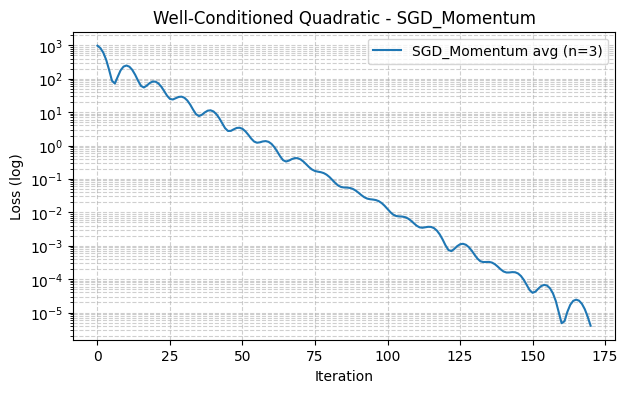

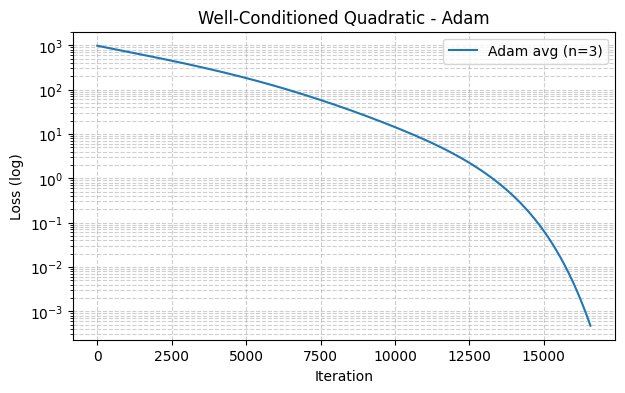

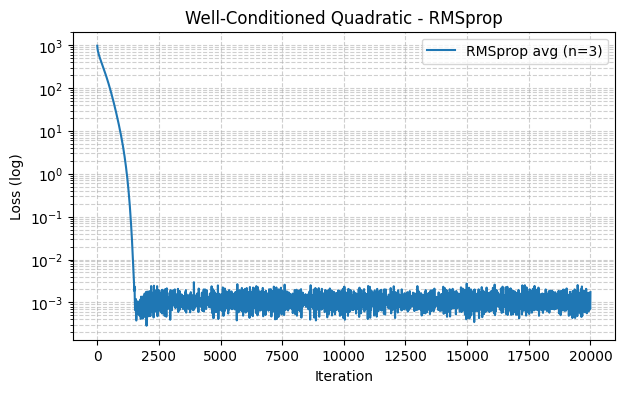

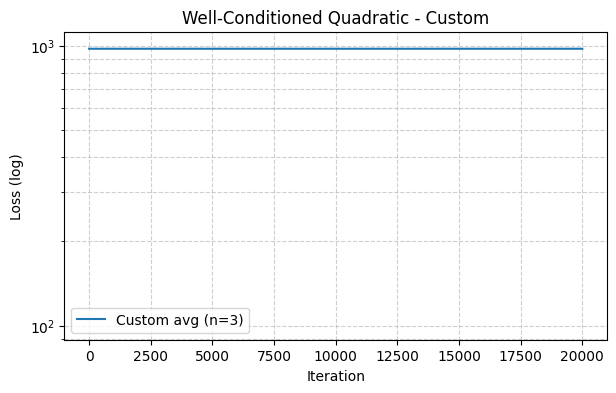

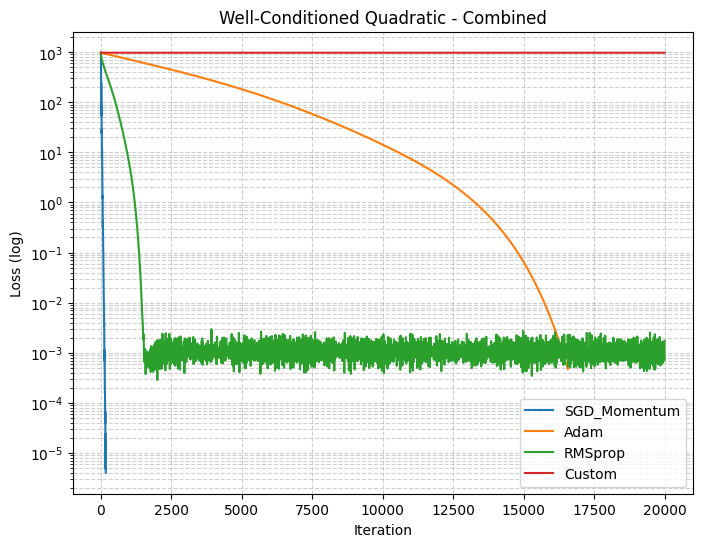


Summary (iterations to reach target, per run):
  SGD_Momentum : [190 170 181] (mean ± std = 180.3 ± 8.2)
  Adam         : [16567 17757 16971] (mean ± std = 17098.3 ± 494.1)
  RMSprop      : [20000 20000 20000] (mean ± std = 20000.0 ± 0.0)
  Custom       : [20000 20000 20000] (mean ± std = 20000.0 ± 0.0)


In [34]:

res = experiment_well_conditioned(n_dim=10, cond_num=10.0, target_loss=1e-6,
                                    max_iter=20000, n_runs=3)
print("\nSummary (iterations to reach target, per run):")
for name, data in res.items():
    arr = np.array(data['iters'])
    print(f"  {name:12s} : {arr} (mean ± std = {arr.mean():.1f} ± {arr.std():.1f})")


In [35]:

res_rosen = experiment_rosenbrock(
    target_loss=1e-4,
    max_iter=20000,
    n_runs=3
)


for name, data in res_rosen.items():
    arr = np.array(data['iters'])
    print(f"  {name:12s} : {arr} (mean ± std = {arr.mean():.1f} ± {arr.std():.1f})")

Start point = [-1.2  1. ]

Run 1/3
  SGD_Momentum -> iters: 836
  Adam       -> iters: 10346
  RMSprop    -> iters: 20000


TypeError: UMG_Torch.__init__() got an unexpected keyword argument 'scale_drop'

In [ ]:
class CustomOptimizer4(optim.Optimizer):
    """
    Adam-like optimizer with gradient-change-based scaling.
    Works fully with PyTorch autograd (uses p.grad).
    No analytic grad_fn required.
    """

    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999,
                 eps=1e-8, scale_drop=0.5):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2,
                        eps=eps, scale_drop=scale_drop)
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                state["t"] = 0
                state["m"] = torch.zeros_like(p.data)
                state["v"] = torch.zeros_like(p.data)
                state["prev_g"] = torch.zeros_like(p.data)
                state["prev_diff"] = float("inf")

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            b1 = group["beta1"]
            b2 = group["beta2"]
            eps = group["eps"]
            scale_drop = group["scale_drop"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                g = p.grad.detach()

                state = self.state[p]
                prev_g = state["prev_g"]

                # t
                state["t"] += 1
                t = state["t"]

                # Adam moment updates
                state["m"] = b1 * state["m"] + (1 - b1) * g
                state["v"] = b2 * state["v"] + (1 - b2) * (g * g)

                m_hat = state["m"] / (1 - b1 ** t)
                v_hat = state["v"] / (1 - b2 ** t)

                # tentative update
                update = lr * m_hat / (torch.sqrt(v_hat) + eps)

                # gradient-difference check
                diff_norm = torch.norm(g - prev_g)

                if diff_norm < state["prev_diff"]:
                    scale = 1.0
                else:
                    scale = scale_drop

                # scale momentum contribution
                state["m"] = b1 * state["m"] + (1 - b1) * g * scale

                # update prev values
                state["prev_diff"] = diff_norm
                state["prev_g"] = g.clone()

                # commit update
                p.data -= update

        return loss


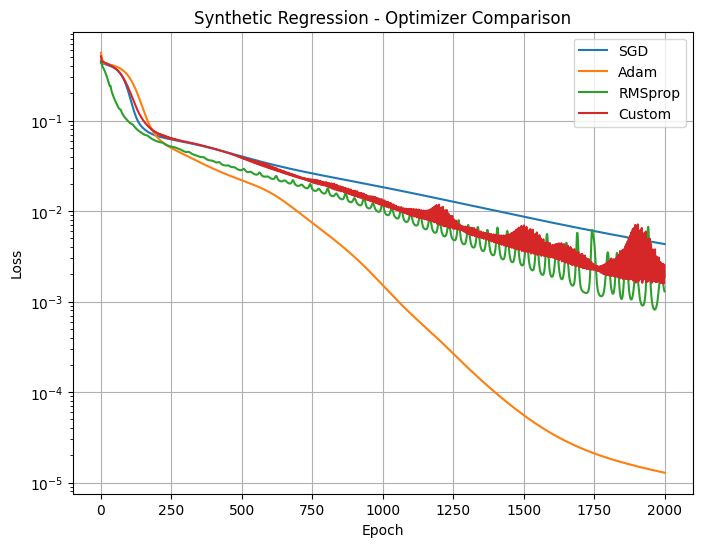

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

dtype = torch.float64
device = "cpu"
torch.manual_seed(0)

# ---------------------------------------
# Synthetic dataset
# ---------------------------------------
x = torch.linspace(-2, 2, 500, dtype=dtype).unsqueeze(1)
y = torch.sin(3*x) + 0.3*x

# ---------------------------------------
# Simple MLP
# ---------------------------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------------------
# Run one optimizer
# ---------------------------------------
def train_model(opt_class, opt_kwargs, epochs=2000):
    model = MLP().to(dtype)
    criterion = nn.MSELoss()

    # Standard torch optimizers
    opt = opt_class(model.parameters(), **opt_kwargs)

    losses = []
    for ep in range(epochs):
        opt.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses

# ---------------------------------------
# Custom optimizer wrapper (uses autograd)
# ---------------------------------------
class CustomWrapper(optim.Optimizer):
    def __init__(self, params, **kwargs):
        params = list(params)         # IMPORTANT
        super().__init__(params, kwargs)
        self.inner = CustomOptimizer4(self.param_groups[0]["params"], **kwargs)

    def step(self, closure=None):
        return self.inner.step(closure)


# ---------------------------------------
# Compare optimizers
# ---------------------------------------
results = {
    "SGD": train_model(optim.SGD, {"lr": 1e-2, "momentum": 0.9}),
    "Adam": train_model(optim.Adam, {"lr": 1e-3}),
    "RMSprop": train_model(optim.RMSprop, {"lr": 1e-3}),
    "Custom": train_model(CustomWrapper, {"lr": 1e-3}),
}

# ---------------------------------------
# Plot losses
# ---------------------------------------
plt.figure(figsize=(8,6))
for k,v in results.items():
    plt.plot(v, label=k)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Synthetic Regression - Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.show()
